# Lab 9: Understanding Convolution Filters

Welcome to Lab 9! In this tutorial, we will explore the heart of Convolutional Neural Networks (CNNs): the **Convolution Operation**. We will look at how small matrices, called **kernels** or **filters**, can be used to transform images for various purposes like blurring, sharpening, and edge detection.

## Table of Contents
1. [The Math of Convolution](#1.-The-Math-of-Convolution)
2. [Hyperparameters: Kernel Size, Stride, and Dilation](#2.-Hyperparameters)
3. [8 Essential Filter Use Cases](#3.-8-Essential-Filter-Use-Cases)

## 1. The Math of Convolution

A convolution operation involves a **kernel** (a small matrix) sliding over an input image. At each position, an element-wise multiplication is performed between the kernel and the part of the image it covers, and the results are summed to produce a single pixel in the output image.

$$\text{Output}(i, j) = \sum_{m} \sum_{n} \text{Input}(i+m, j+n) \cdot \text{Kernel}(m, n)$$

This process allows the network to learn local features!

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests
from io import BytesIO

# Helper function to display images
def plot_comparison(original, filtered, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(original, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title(title)
    # We use vmin/vmax to ensure edges (which might be negative) are visible
    plt.imshow(filtered, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Helper to create a structured synthetic image if download fails
def create_synthetic_image(size=(256, 256)):
    # Create an image with a dark gray background
    image = Image.new('L', size, color=128)
    draw = ImageDraw.Draw(image)
    # Add high-contrast shapes for edge detection testing
    draw.rectangle([40, 40, 216, 216], outline=255, fill=0, width=4) # Large rectangle
    draw.ellipse([80, 80, 176, 176], outline=255, fill=200) # Internal circle
    draw.line([0, 0, 256, 256], fill=255, width=5) # Diagonal line
    draw.text((10, 10), "TEST IMAGE", fill=255)
    return image

# Load a sample image
try:
    # Attempt to load a reliable test image
    url = 'https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg'
    response = requests.get(url, timeout=5)
    img = Image.open(BytesIO(response.content)).convert('L')
    print("Successfully loaded Lena image from URL.")
except Exception as e:
    print(f"Warning: Could not load image from URL ({e}). Using synthetic structural image.")
    img = create_synthetic_image()

# Convert image to tensor (1, 1, H, W) and normalize to [0, 1]
img_tensor = torch.from_numpy(np.array(img)).unsqueeze(0).unsqueeze(0).float() / 255.0
print(f"Input image shape: {img_tensor.shape}")

Successfully loaded Lena image from URL.
Input image shape: torch.Size([1, 1, 512, 512])


## 2. Hyperparameters: Kernel Size, Stride, and Dilation

- **Kernel Size**: Dimensions of the filter (e.g. 3x3).
- **Stride**: Step size the filter moves.
- **Dilation**: Spacing between kernel elements (spreads the field without adding parameters).

In [2]:
# Demonstrate Hyperparameters
kernel_3x3 = torch.ones(1, 1, 3, 3) / 9.0
out_norm = F.conv2d(img_tensor, kernel_3x3, padding=1)
out_stride2 = F.conv2d(img_tensor, kernel_3x3, stride=2, padding=1)
out_dilation2 = F.conv2d(img_tensor, kernel_3x3, dilation=2, padding=2)

print(f'Original: {img_tensor.shape}')
print(f'Stride 2: {out_stride2.shape}')
print(f'Dilation 2: {out_dilation2.shape}')

Original: torch.Size([1, 1, 512, 512])
Stride 2: torch.Size([1, 1, 256, 256])
Dilation 2: torch.Size([1, 1, 512, 512])


## 3. 8 Essential Filter Use Cases

### 1. Identity
Keeps the image unchanged.

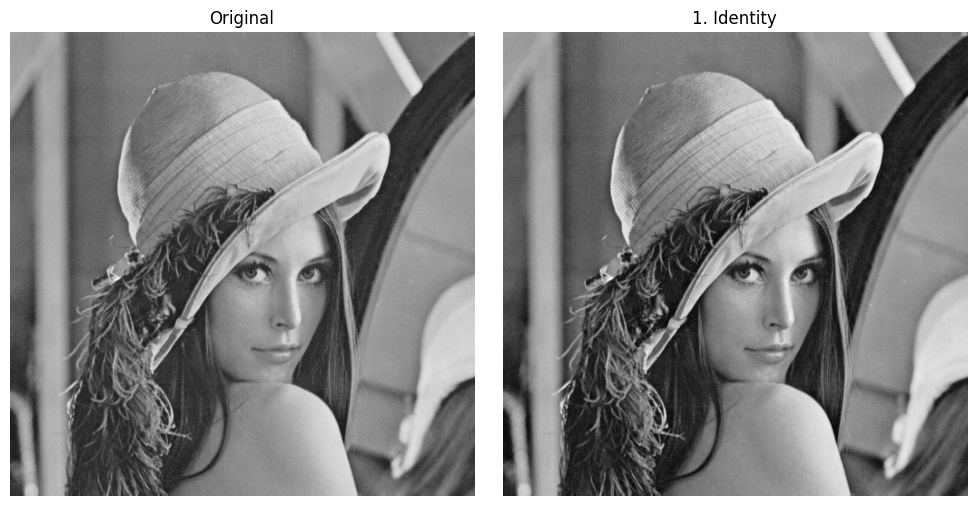

In [16]:
kernel = torch.tensor([
    [0, 0, 0], 
    [0, 1, 0], 
    [0, 0, 0]
]).float().unsqueeze(0).unsqueeze(0)
output = F.conv2d(img_tensor, kernel, padding=1)
plot_comparison(img_tensor[0,0].numpy(), output[0,0].numpy(), '1. Identity')

### 2. Box Blur
Averages neighboring pixels to smooth.

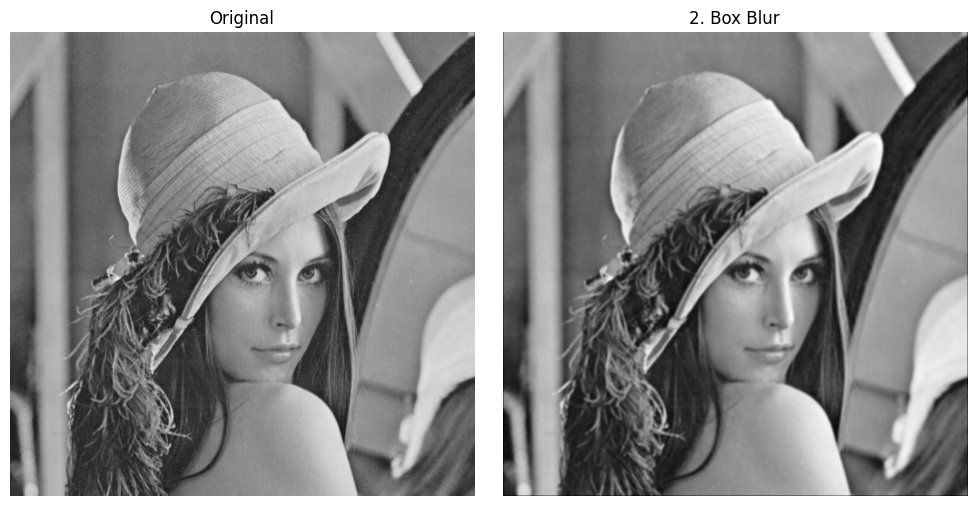

In [18]:
kernel = torch.tensor([
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9]]).float().unsqueeze(0).unsqueeze(0)
output = F.conv2d(img_tensor, kernel, padding=1)
plot_comparison(img_tensor[0,0].numpy(), output[0,0].numpy(), '2. Box Blur')

### 3. Gaussian Blur
Weight-based smoothing (weighted toward center).

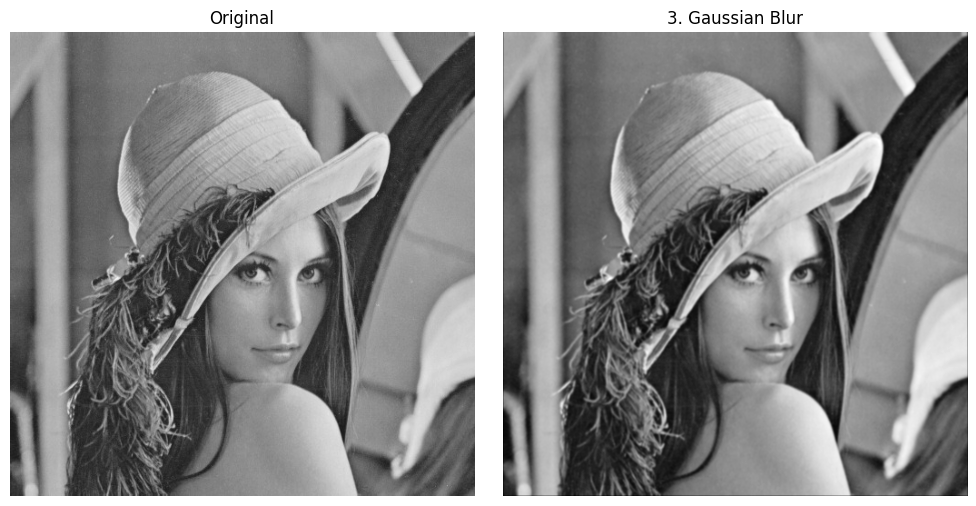

In [19]:
kernel = torch.tensor([
    [1/16, 2/16, 1/16],
    [2/16, 4/16, 2/16],
    [1/16, 2/16, 1/16]
]).float().unsqueeze(0).unsqueeze(0)
output = F.conv2d(img_tensor, kernel, padding=1)
plot_comparison(img_tensor[0,0].numpy(), output[0,0].numpy(), '3. Gaussian Blur')

### 4. Sobel Horizontal
Highlights horizontal edges (intensity changes).

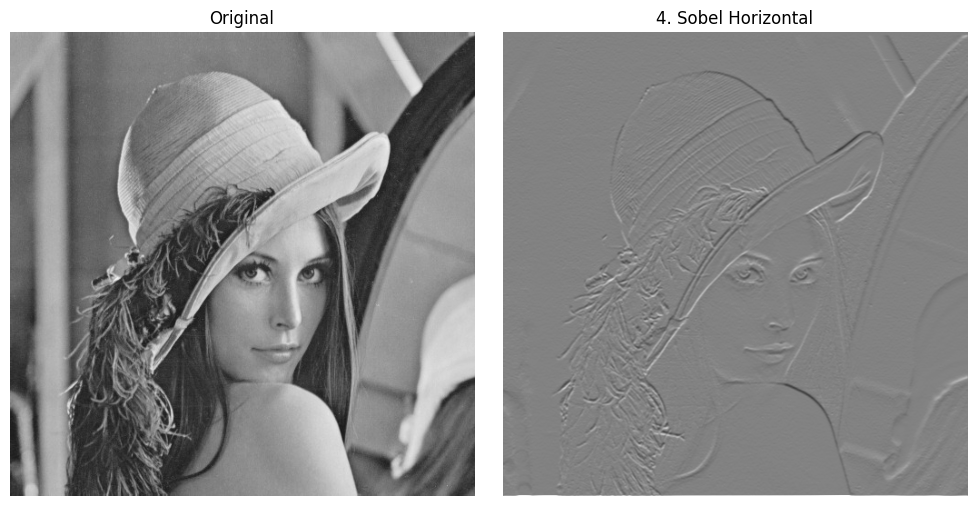

In [25]:
kernel = torch.tensor([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]]).float().unsqueeze(0).unsqueeze(0)
output = F.conv2d(img_tensor, kernel, padding=1)
plot_comparison(img_tensor[0,0].numpy(), output[0,0].numpy(), '4. Sobel Horizontal')

### 5. Sharpen
Increases local contrast.

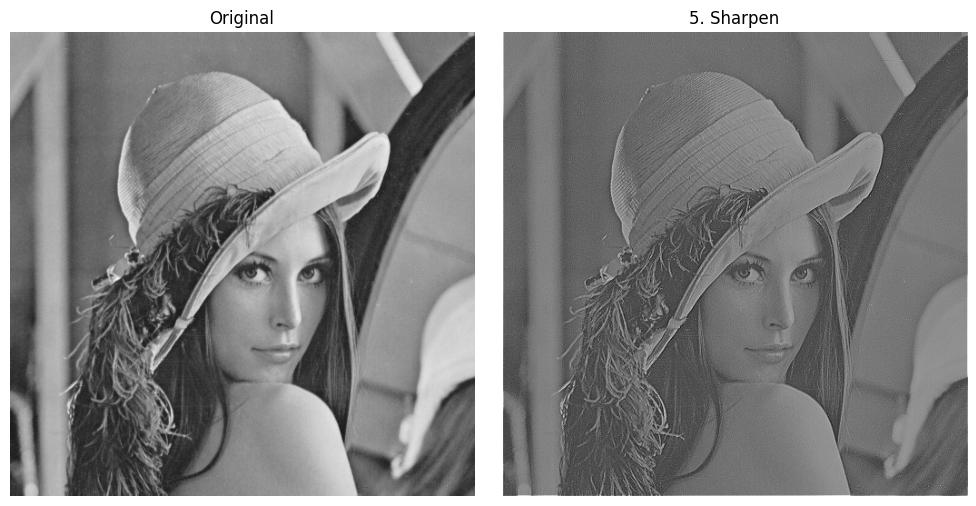

In [7]:
kernel = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]]).float().unsqueeze(0).unsqueeze(0)
output = F.conv2d(img_tensor, kernel, padding=1)
plot_comparison(img_tensor[0,0].numpy(), output[0,0].numpy(), '5. Sharpen')

### 6. Emboss
Creates a 3D shadow effect.

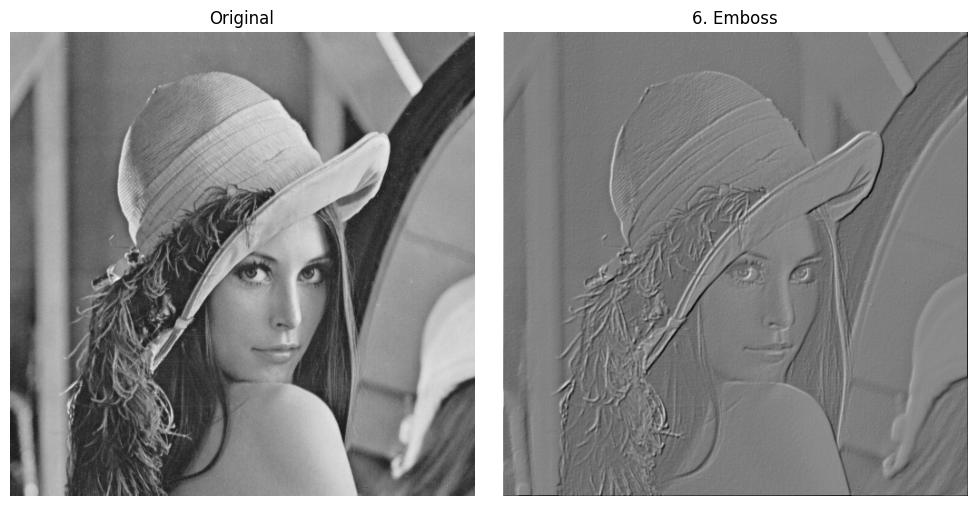

In [8]:
kernel = torch.tensor([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2]]).float().unsqueeze(0).unsqueeze(0)
output = F.conv2d(img_tensor, kernel, padding=1)
plot_comparison(img_tensor[0,0].numpy(), output[0,0].numpy(), '6. Emboss')

### 7. Laplacian
Finds areas of rapid change.

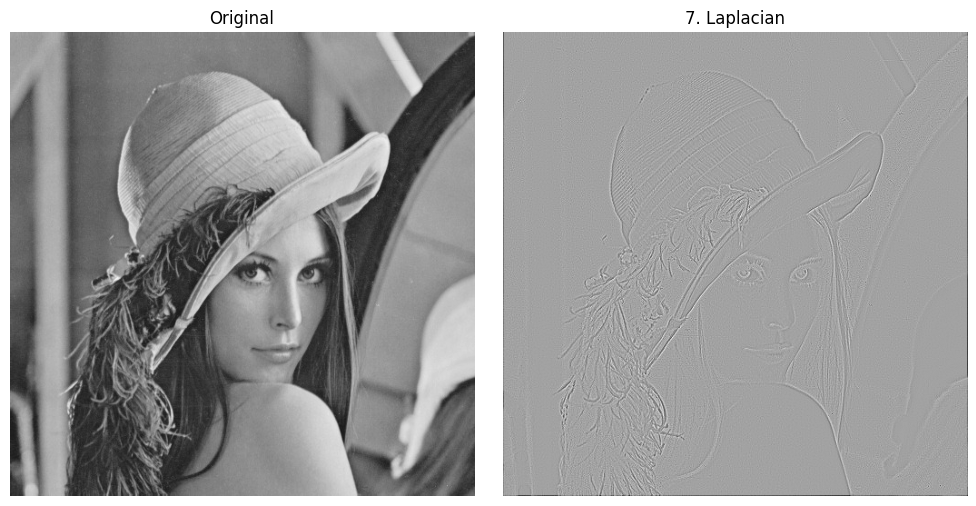

In [33]:
kernel = torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]]).float().unsqueeze(0).unsqueeze(0)
output = F.conv2d(img_tensor, kernel, padding=1)
plot_comparison(img_tensor[0,0].numpy(), output[0,0].numpy(), '7. Laplacian')

### 8. Ridge Detection
Outlines the shapes in the image.

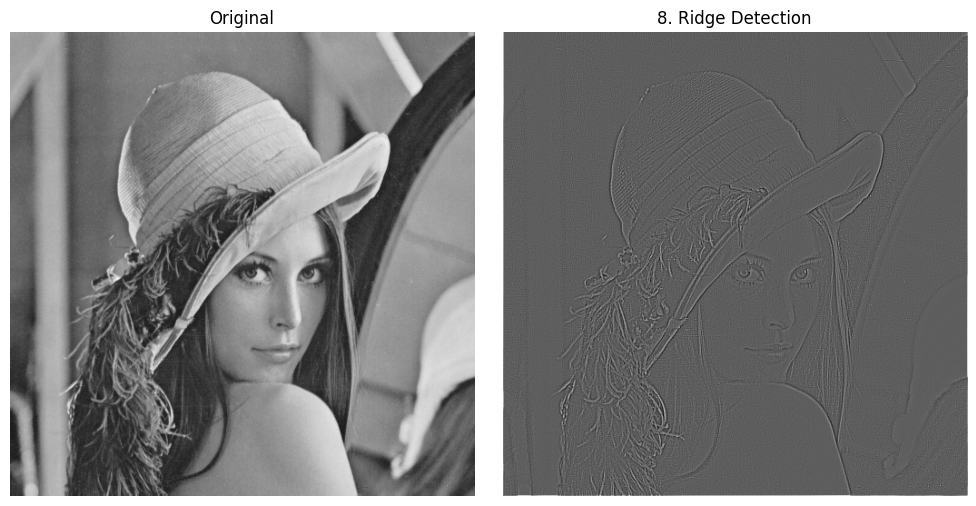

In [40]:
kernel = torch.tensor([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]]).float().unsqueeze(0).unsqueeze(0)
output = F.conv2d(img_tensor, kernel, padding=1)
plot_comparison(img_tensor[0,0].numpy(), output[0,0].numpy(), '8. Ridge Detection')